In [1]:
import numpy as np
import pandas as pd
import math
import time
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.ndimage as ndimage
import matplotlib.gridspec as gridspec

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import lightgbm as lgb

import torch
import torch.nn as nn
import torch.nn.functional as F
from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping

In [2]:
CUBE_PATH = "../sdss_cube_sfr/SDSS_cube_lean.h5"
sfrs = pd.read_hdf(CUBE_PATH, key="fits_spectra_metadata_star_formation_rates")
with h5py.File(CUBE_PATH, "r") as cube:
    metadata = cube["dense_cube/0/ml_spectrum/spec_metadata_refs"][:]
metadata_indices = metadata[:, 0]["ds_slice_idx"]

# Data exploration and processing:

In [3]:
sfrs = sfrs[sfrs.index.isin(metadata_indices)].copy()
sfrs = sfrs[sfrs["AVG"].notna()].copy()
sfrs_filtered = sfrs[sfrs["AVG"] >= -80].copy()
sfrs_flag0_filtered = sfrs_filtered[sfrs_filtered["FLAG"] == 0.0].copy()
sfrs_flag_not0_filtered = sfrs_filtered[sfrs_filtered["FLAG"] != 0.0].copy()

print("Total records in sfrs (before filtering by image/spectrum):", len(sfrs))
print("Total records after filtering by image/spectrum availability:", len(sfrs))
print("Total records after removing NaN in AVG:", len(sfrs))
print("Total records after filtering AVG >= -80:", len(sfrs_filtered))
print("Among them, FLAG == 0:", len(sfrs_flag0_filtered))
print("Among them, FLAG != 0:", len(sfrs_flag_not0_filtered))

sfrs_flag0 = sfrs[sfrs["FLAG"] == 0.0]
labels_pie = ["FLAG == 0", "FLAG != 0"]
sizes = [len(sfrs_flag0), len(sfrs) - len(sfrs_flag0)]

Total records in sfrs (before filtering by image/spectrum): 34613
Total records after filtering by image/spectrum availability: 34613
Total records after removing NaN in AVG: 34613
Total records after filtering AVG >= -80: 30752
Among them, FLAG == 0: 16841
Among them, FLAG != 0: 13911


In [4]:
mask_all = np.in1d(metadata_indices, sfrs_filtered.index)
mask_flag0 = np.in1d(metadata_indices, sfrs_flag0_filtered.index)
selected_all = metadata_indices[mask_all]
selected_flag0 = metadata_indices[mask_flag0]

all_images = []
all_spectra = []
filtered_images = []
filtered_spectra = []

for zoom in range(4):
    img_key = f"dense_cube/{zoom}/ml_image/cutout_3d_cube_zoom_{zoom}"
    spec_key = f"dense_cube/{zoom}/ml_spectrum/spectral_1d_cube_zoom_{zoom}"
    with h5py.File(CUBE_PATH, "r") as cube:
        images_zoom = cube[img_key][:][mask_all]
        spectra_zoom = cube[spec_key][:][mask_all]
    all_images.append(images_zoom)
    all_spectra.append(spectra_zoom)
    with h5py.File(CUBE_PATH, "r") as cube:
        images_zoom_flag0 = cube[img_key][:][mask_flag0]
        spectra_zoom_flag0 = cube[spec_key][:][mask_flag0]
    filtered_images.append(images_zoom_flag0)
    filtered_spectra.append(spectra_zoom_flag0)

print("All images shape (zoom 0):", all_images[0].shape)
print("Filtered images shape (zoom 0):", filtered_images[0].shape)
print("All spectra shape (zoom 0):", all_spectra[0].shape)
print("Filtered spectra shape (zoom 0):", filtered_spectra[0].shape)

All images shape (zoom 0): (30752, 5, 64, 64)
Filtered images shape (zoom 0): (16841, 5, 64, 64)
All spectra shape (zoom 0): (30752, 4620)
Filtered spectra shape (zoom 0): (16841, 4620)


In [5]:
nan_counts_all = np.sum(np.isnan(all_spectra[0]), axis=1)
nan_counts_flag0 = np.sum(np.isnan(filtered_spectra[0]), axis=1)
total_length = all_spectra[0].shape[1]

In [6]:
total_length = all_spectra[0].shape[1]
wavelengths = np.linspace(3800, 9200, total_length)

fraction_nan_all = np.mean(np.isnan(all_spectra[0]), axis=0)
fraction_nan_flag0 = np.mean(np.isnan(filtered_spectra[0]), axis=0)

### Delete all the spectra that contain nan:

In [7]:
mask_clean_all = ~np.isnan(all_spectra[0]).any(axis=1)
mask_clean_flag0 = ~np.isnan(filtered_spectra[0]).any(axis=1)

cleaned_all_images = [arr[mask_clean_all] for arr in all_images]
cleaned_all_spectra = [arr[mask_clean_all] for arr in all_spectra]

cleaned_filtered_images = [arr[mask_clean_flag0] for arr in filtered_images]
cleaned_filtered_spectra = [arr[mask_clean_flag0] for arr in filtered_spectra]

selected_all_clean = selected_all[mask_clean_all]
selected_flag0_clean = selected_flag0[mask_clean_flag0]

cleaned_sfrs_all = sfrs_filtered.loc[selected_all_clean]
cleaned_sfrs_flag0 = sfrs_flag0_filtered.loc[selected_flag0_clean]

print("Cleaned All spectra shape (zoom 0):", cleaned_all_spectra[0].shape)
print("Cleaned FLAG==0 spectra shape (zoom 0):", cleaned_filtered_spectra[0].shape)
print("Spectra removed (all):", all_spectra[0].shape[0] - cleaned_all_spectra[0].shape[0])
print("Spectra removed (FLAG==0):", filtered_spectra[0].shape[0] - cleaned_filtered_spectra[0].shape[0])

print("\nCleaned All images shape (zoom 0):", cleaned_all_images[0].shape)
print("Cleaned FLAG==0 images shape (zoom 0):", cleaned_filtered_images[0].shape)
print("Images removed (all):", all_images[0].shape[0] - cleaned_all_images[0].shape[0])
print("Images removed (FLAG==0):", filtered_images[0].shape[0] - cleaned_filtered_images[0].shape[0])

print("\nCleaned SFR (all) shape:", cleaned_sfrs_all.shape)
print("Cleaned SFR (FLAG==0) shape:", cleaned_sfrs_flag0.shape)
print("SFR records removed (all):", sfrs_filtered.shape[0] - cleaned_sfrs_all.shape[0])
print("SFR records removed (FLAG==0):", sfrs_flag0_filtered.shape[0] - cleaned_sfrs_flag0.shape[0])


Cleaned All spectra shape (zoom 0): (20157, 4620)
Cleaned FLAG==0 spectra shape (zoom 0): (11179, 4620)
Spectra removed (all): 10595
Spectra removed (FLAG==0): 5662

Cleaned All images shape (zoom 0): (20157, 5, 64, 64)
Cleaned FLAG==0 images shape (zoom 0): (11179, 5, 64, 64)
Images removed (all): 10595
Images removed (FLAG==0): 5662

Cleaned SFR (all) shape: (20157, 284)
Cleaned SFR (FLAG==0) shape: (11179, 284)
SFR records removed (all): 10595
SFR records removed (FLAG==0): 5662


In [8]:
def normalize_images(images_list):
    normalized_list = []
    for img_array in images_list:
        min_val = np.min(img_array, axis=(2,3), keepdims=True)
        max_val = np.max(img_array, axis=(2,3), keepdims=True)
        norm_img = 2 * (img_array - min_val) / (max_val - min_val) - 1
        normalized_list.append(norm_img)
    return normalized_list

normalized_all_images = normalize_images(cleaned_all_images)
normalized_filtered_images = normalize_images(cleaned_filtered_images)

In [9]:
labels_flag0 = sfrs_flag0_filtered.loc[:, "TARGETTYPE"]
labels_flag_not0 = sfrs_filtered.loc[sfrs_filtered["FLAG"] != 0.0, "TARGETTYPE"]

def simplify_targettype(val):
    if isinstance(val, bytes):
        val = val.decode("utf-8").strip()
    else:
        val = str(val).strip()
    if "GALAXY" in val:
        return "GALAXY"
    elif "QSO" in val or "QA" in val:
        return "QUASAR"
    elif "STAR" in val:
        return "STAR"
    else:
        return "OTHER"

df_flag0_orig = pd.DataFrame({"TARGETTYPE": labels_flag0})
df_flag_not0_orig = pd.DataFrame({"TARGETTYPE": labels_flag_not0})

df_flag0_simpl = pd.DataFrame({"Simplified_TARGETTYPE": pd.Series(labels_flag0).apply(simplify_targettype)})
df_flag_not0_simpl = pd.DataFrame({"Simplified_TARGETTYPE": pd.Series(labels_flag_not0).apply(simplify_targettype)})

In [10]:
def normalize_spectra(spectra_list):
    normalized_list = []
    for spec in spectra_list:
        if spec.ndim == 1:
            spec = spec[np.newaxis, :]
        min_val = np.nanmin(spec, axis=1, keepdims=True)
        max_val = np.nanmax(spec, axis=1, keepdims=True)
        diff = np.where((max_val - min_val)==0, 1, max_val - min_val)
        norm_spec = 2 * (spec - min_val) / diff - 1
        normalized_list.append(norm_spec)
    result = np.empty(len(normalized_list), dtype=object)
    for i, arr in enumerate(normalized_list):
        result[i] = arr
    return result

normalized_all_spectra = normalize_spectra(cleaned_all_spectra)
normalized_filtered_spectra = normalize_spectra(cleaned_filtered_spectra)

## Getting rid of photos with multiple objects:

In [11]:
flag0_indices = cleaned_sfrs_flag0.index
all_indices = cleaned_sfrs_all.index
flag_not0_indices = all_indices.difference(flag0_indices)
mask_flag_not0 = np.isin(cleaned_sfrs_all.index, flag_not0_indices)
normalized_nonflag0_images = [arr[mask_flag_not0] for arr in normalized_all_images]

In [12]:
CROP_SIZES_4 = {
    0: 32,  # originally 64
    1: 16,  # originally 32
    2: 8,   # originally 16
    3: 4    # originally 8
}
THRESHOLD = 0.9

def detect_and_visualize_multiple_objects(images_list, thresholds, crop_sizes=None, max_objects=1, thumbnail_size=3, group_name="", print_spectra=False, spectra_list=None):
    images_trimmed = []
    for i, img_array in enumerate(images_list):
        original_size = img_array.shape[-1]
        target_size = crop_sizes.get(i, original_size) if crop_sizes is not None else original_size
        start = (original_size - target_size) // 2
        end = start + target_size
        trimmed = img_array[..., start:end, start:end]
        images_trimmed.append(trimmed)
    multi_obj_indices = []
    for idx in range(images_trimmed[0].shape[0]):
        image = images_trimmed[0][idx, 2, :, :]
        image_normalized = (image + 1) / 2
        binary = image_normalized > thresholds
        labeled, num_features = ndimage.label(binary)
        if num_features > 1:
            multi_obj_indices.append(idx)
    total_images = images_trimmed[0].shape[0]
    count_multi = len(multi_obj_indices)
    percent_multi = (count_multi / total_images)*100 if total_images>0 else 0
    print(f"{group_name}: Found {count_multi} images with multiple objects from {total_images} ({percent_multi:.2f}%).")
    if multi_obj_indices:
        display_indices = multi_obj_indices[:max_objects]
        if print_spectra and spectra_list is not None:
            num_disp = len(display_indices)
            fig = plt.figure(figsize=(15, thumbnail_size * 2 * num_disp), dpi=100)
            gs = gridspec.GridSpec(2 * num_disp, 5, hspace=0.6, wspace=0.3)
            for i, obj_idx in enumerate(display_indices):
                for col in range(5):
                    ax = fig.add_subplot(gs[2*i, col])
                    img_data = images_trimmed[0][obj_idx, col, :, :]
                    ax.imshow(img_data, vmin=-1, vmax=1)
                    ax.set_title(f"Filter {col}", fontsize=10)
                    ax.axis("off")
                ax_spec = fig.add_subplot(gs[2*i+1, :])
                spectrum = spectra_list[0][obj_idx]
                wavelengths = np.linspace(3800,9200, len(spectrum))
                ax_spec.plot(wavelengths, spectrum, color="blue", linewidth=0.3)
                ax_spec.set_title("Spectrum (Zoom 0)", fontsize=10)
                ax_spec.set_xlabel("Wavelength (Å)", fontsize=10)
                ax_spec.set_ylabel("Flux", fontsize=10)
                ax_spec.set_xlim([3800,9200])
                ax_spec.set_ylim([-1,1])
            fig.suptitle(f"Images with ≥2 objects and spectra ({group_name})", fontsize=14)
            fig.tight_layout()
            fig.subplots_adjust(top=0.93)
            plt.show()
        else:
            num_disp = len(display_indices)
            fig, axes = plt.subplots(num_disp, 5, figsize=(15, thumbnail_size * num_disp), dpi=100)
            if num_disp == 1:
                axes = axes.reshape(1, -1)
            for row, obj_idx in enumerate(display_indices):
                for col in range(5):
                    ax = axes[row, col]
                    img_data = images_trimmed[0][obj_idx, col, :, :]
                    ax.imshow(img_data, vmin=-1, vmax=1)
                    ax.set_title(f"Filter {col}", fontsize=10)
                    ax.axis("off")
            fig.suptitle(f"Images with ≥2 objects ({group_name})", fontsize=14)
            fig.tight_layout()
            fig.subplots_adjust(top=0.99)
            plt.show()
    else:
        print(f"No images found for {group_name} with multiple objects.")
    return images_trimmed, multi_obj_indices

FLAG != 0 (Original): Found 1184 images with multiple objects from 8978 (13.19%).


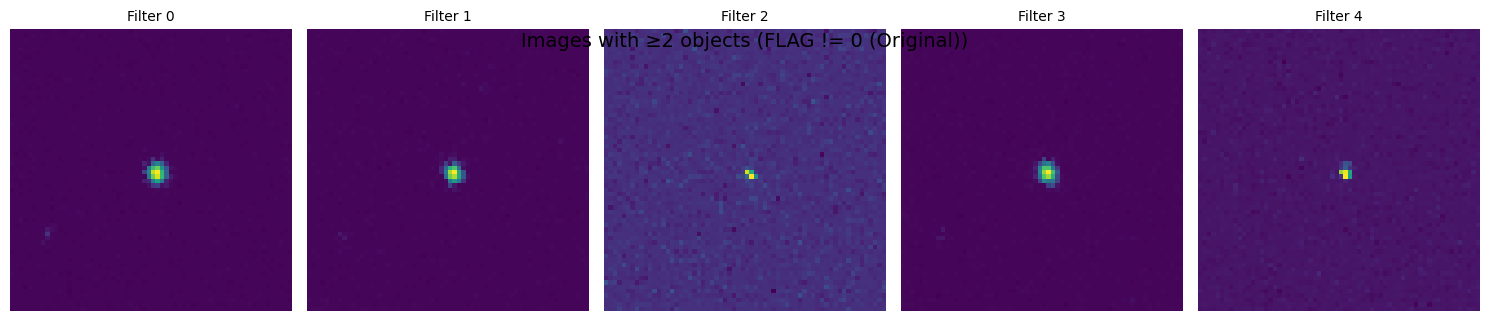

In [13]:
orig_images_flag_not0, multi_obj_indices_flag_not0 = detect_and_visualize_multiple_objects(normalized_nonflag0_images, thresholds=THRESHOLD, crop_sizes=None, group_name="FLAG != 0 (Original)", print_spectra=False, spectra_list=normalized_filtered_spectra)

FLAG == 0 (Original): Found 1111 images with multiple objects from 11179 (9.94%).


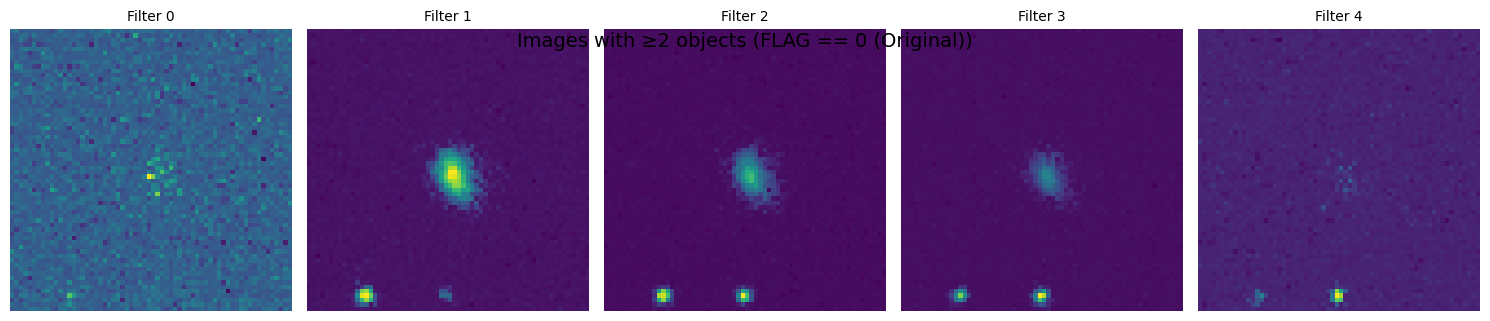

In [14]:
orig_images_flag0, multi_obj_indices_flag0 = detect_and_visualize_multiple_objects(normalized_filtered_images, thresholds=THRESHOLD, crop_sizes=None, group_name="FLAG == 0 (Original)", print_spectra=False, spectra_list=normalized_filtered_spectra)

# Machine Learning (FLAG == 0 only):

In [15]:
def run_grid_search_lgb(X, Y, param_grid):
    X_flat = X.reshape(X.shape[0], -1)
    X_train, X_val, Y_train, Y_val = train_test_split(X_flat, Y, test_size=0.2, random_state=42)
    model = lgb.LGBMRegressor(random_state=42)
    grid = GridSearchCV(model, param_grid, scoring='r2', cv=5)
    grid.fit(X_train, Y_train)
    best_score = grid.best_score_
    best_params = grid.best_params_
    best_model = grid.best_estimator_
    y_val_pred = best_model.predict(X_val)
    mae = mean_absolute_error(Y_val, y_val_pred)
    r2_val = r2_score(Y_val, y_val_pred)
    error = y_val_pred - Y_val
    nmad = 1.4826 * np.median(np.abs(error - np.median(error)))
    rmse = np.sqrt(mean_squared_error(Y_val, y_val_pred))
    return best_score, best_params, mae, r2_val, nmad, rmse, best_model, X_val, Y_val


param_grid_lgb = {
    'max_depth': [10, 15],
    'learning_rate': [0.1, 0.01]
}

selected_Y_flag0 = cleaned_sfrs_flag0.loc[selected_flag0_clean]["AVG"].values

results = {'Original Img': {}, 'Cropped Img': {}, 'Spectra': {}}

In [16]:
Y_all = selected_Y_flag0

if f'zoom_{0}' not in results['Original Img']:
    bs, bp, m, r, n, rm, bm, Xv, Yv = run_grid_search_lgb(orig_images_flag0[0], Y_all if orig_images_flag0[0].shape[0]==len(Y_all) else Y_all[:orig_images_flag0[0].shape[0]], param_grid_lgb)
    results['Original Img'][f'zoom_{0}'] = {'best_cv_score': bs, 'best_params': bp, 'mae': m, 'r2': r, 'nmad': n, 'rmse': rm}
if f'zoom_{0}' not in results['Spectra']:
    # If not available, set default 0 values
    results['Spectra'][f'zoom_{0}'] = {'best_cv_score': 0, 'best_params': {}, 'mae': 0, 'r2': 0, 'nmad': 0, 'rmse': 0}

photo_candidate = ("Original Img", 0, results['Original Img'][f'zoom_{0}']['mae'], orig_images_flag0[0])
spectra_candidate = ("Spectra", 0, results['Spectra'][f'zoom_{0}']['mae'], normalized_filtered_spectra[0])

print("Photo candidate:", photo_candidate[0], "zoom", photo_candidate[1])
print("Spectra candidate:", spectra_candidate[0], "zoom", spectra_candidate[1])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.812415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222399
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 20480
[LightGBM] [Info] Start training from score -0.179390
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.894105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222400
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 20480
[LightGBM] [Info] Start training from score -0.172975
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.904504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222400
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 20480
[LightGBM] [Info] Start training from score -0.179095
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.915276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222400
[LightGBM] [Info] Number of data points in the train set: 7155, number of used features: 20480
[LightGBM] [Info] Start training from score -0.171445
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.886102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222399
[LightGBM] [Info] Number of data points in the train set: 7155, number of used features: 20480
[LightGBM] [Info] Start training from score -0.179057
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.881462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222399
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 20480
[LightGBM] [Info] Start training from score -0.179390
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.604733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222400
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 20480
[LightGBM] [Info] Start training from score -0.172975
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.818602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222400
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 20480
[LightGBM] [Info] Start training from score -0.179095
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.761462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222400
[LightGBM] [Info] Number of data points in the train set: 7155, number of used features: 20480
[LightGBM] [Info] Start training from score -0.171445
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.525687 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222399
[LightGBM] [Info] Number of data points in the train set: 7155, number of used features: 20480
[LightGBM] [Info] Start training from score -0.179057
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.778827 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222399
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 20480
[LightGBM] [Info] Start training from score -0.179390


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.598513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222400
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 20480
[LightGBM] [Info] Start training from score -0.172975


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.496305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222400
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 20480
[LightGBM] [Info] Start training from score -0.179095


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.536904 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222400
[LightGBM] [Info] Number of data points in the train set: 7155, number of used features: 20480
[LightGBM] [Info] Start training from score -0.171445


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.741934 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222399
[LightGBM] [Info] Number of data points in the train set: 7155, number of used features: 20480
[LightGBM] [Info] Start training from score -0.179057


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.552935 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222399
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 20480
[LightGBM] [Info] Start training from score -0.179390


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.491014 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222400
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 20480
[LightGBM] [Info] Start training from score -0.172975


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.502297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222400
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 20480
[LightGBM] [Info] Start training from score -0.179095


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.723075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222400
[LightGBM] [Info] Number of data points in the train set: 7155, number of used features: 20480
[LightGBM] [Info] Start training from score -0.171445


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.709731 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222399
[LightGBM] [Info] Number of data points in the train set: 7155, number of used features: 20480
[LightGBM] [Info] Start training from score -0.179057


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.005359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222400
[LightGBM] [Info] Number of data points in the train set: 8943, number of used features: 20480
[LightGBM] [Info] Start training from score -0.176393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Photo candidate: Original Img zoom 0
Spectra candidate: Spectra zoom 0


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [17]:
n_samples = min(photo_candidate[3].shape[0], spectra_candidate[3].shape[0], len(Y_all))
X_photo = photo_candidate[3][:n_samples]
X_spec = spectra_candidate[3][:n_samples]
Y = Y_all[:n_samples]
runtime = {}

# LGBM

### LGBM on Photo:

In [18]:
start = time.time()
lgb_photo_score, lgb_photo_params, lgb_photo_mae, lgb_photo_r2, lgb_photo_nmad, lgb_photo_rmse, _, _, _ = run_grid_search_lgb(X_photo, Y, param_grid_lgb)
lgb_photo = {'r2': lgb_photo_r2, 'mae': lgb_photo_mae, 'nmad': lgb_photo_nmad, 'rmse': lgb_photo_rmse}
runtime["LGBM Photo"] = time.time() - start
print(f"LGBM Photo best params: {lgb_photo_params}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.495897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222399
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 20480
[LightGBM] [Info] Start training from score -0.179390
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.754483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222400
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 20480
[LightGBM] [Info] Start training from score -0.172975
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.617089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222400
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 20480
[LightGBM] [Info] Start training from score -0.179095
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.781402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222400
[LightGBM] [Info] Number of data points in the train set: 7155, number of used features: 20480
[LightGBM] [Info] Start training from score -0.171445
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.786591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222399
[LightGBM] [Info] Number of data points in the train set: 7155, number of used features: 20480
[LightGBM] [Info] Start training from score -0.179057
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.550843 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222399
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 20480
[LightGBM] [Info] Start training from score -0.179390
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.548065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222400
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 20480
[LightGBM] [Info] Start training from score -0.172975
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.766529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222400
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 20480
[LightGBM] [Info] Start training from score -0.179095
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.789872 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222400
[LightGBM] [Info] Number of data points in the train set: 7155, number of used features: 20480
[LightGBM] [Info] Start training from score -0.171445
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.782093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222399
[LightGBM] [Info] Number of data points in the train set: 7155, number of used features: 20480
[LightGBM] [Info] Start training from score -0.179057
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.769042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222399
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 20480
[LightGBM] [Info] Start training from score -0.179390


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.547577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222400
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 20480
[LightGBM] [Info] Start training from score -0.172975


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.580136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222400
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 20480
[LightGBM] [Info] Start training from score -0.179095


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.712064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222400
[LightGBM] [Info] Number of data points in the train set: 7155, number of used features: 20480
[LightGBM] [Info] Start training from score -0.171445


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.678958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222399
[LightGBM] [Info] Number of data points in the train set: 7155, number of used features: 20480
[LightGBM] [Info] Start training from score -0.179057


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.579326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222399
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 20480
[LightGBM] [Info] Start training from score -0.179390


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.582958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222400
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 20480
[LightGBM] [Info] Start training from score -0.172975


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.514087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222400
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 20480
[LightGBM] [Info] Start training from score -0.179095


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.462743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222400
[LightGBM] [Info] Number of data points in the train set: 7155, number of used features: 20480
[LightGBM] [Info] Start training from score -0.171445


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.466196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222399
[LightGBM] [Info] Number of data points in the train set: 7155, number of used features: 20480
[LightGBM] [Info] Start training from score -0.179057


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.963198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222400
[LightGBM] [Info] Number of data points in the train set: 8943, number of used features: 20480
[LightGBM] [Info] Start training from score -0.176393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LGBM Photo best params: {'learning_rate': 0.1, 'max_depth': 15}


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


### LGBM on Spectra:

In [19]:
start = time.time()
lgb_spec_score, lgb_spec_params, lgb_spec_mae, lgb_spec_r2, lgb_spec_nmad, lgb_spec_rmse, _, _, _ = run_grid_search_lgb(X_spec, Y, param_grid_lgb)
lgb_spec = {'r2': lgb_spec_r2, 'mae': lgb_spec_mae, 'nmad': lgb_spec_nmad, 'rmse': lgb_spec_rmse}
runtime["LGBM Spectra"] = time.time() - start
print(f"LGBM Spectra best params: {lgb_spec_params}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.325439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1178098
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 4620
[LightGBM] [Info] Start training from score -0.179390
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.330979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1178098
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 4620
[LightGBM] [Info] Start training from score -0.172975
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.330264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1178098
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 4620
[LightGBM] [Info] Start training from score -0.179095
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.330616 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1178097
[LightGBM] [Info] Number of data points in the train set: 7155, number of used features: 4620
[LightGBM] [Info] Start training from score -0.171445
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.331310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1178098
[LightGBM] [Info] Number of data points in the train set: 7155, number of used features: 4620
[LightGBM] [Info] Start training from score -0.179057
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.328581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1178098
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 4620
[LightGBM] [Info] Start training from score -0.179390
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.327354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1178098
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 4620
[LightGBM] [Info] Start training from score -0.172975
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.327219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1178098
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 4620
[LightGBM] [Info] Start training from score -0.179095
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.329323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1178097
[LightGBM] [Info] Number of data points in the train set: 7155, number of used features: 4620
[LightGBM] [Info] Start training from score -0.171445
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.329411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1178098
[LightGBM] [Info] Number of data points in the train set: 7155, number of used features: 4620
[LightGBM] [Info] Start training from score -0.179057
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.323593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1178098
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 4620
[LightGBM] [Info] Start training from score -0.179390


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.330112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1178098
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 4620
[LightGBM] [Info] Start training from score -0.172975


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.328650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1178098
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 4620
[LightGBM] [Info] Start training from score -0.179095


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.329472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1178097
[LightGBM] [Info] Number of data points in the train set: 7155, number of used features: 4620
[LightGBM] [Info] Start training from score -0.171445


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.329713 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1178098
[LightGBM] [Info] Number of data points in the train set: 7155, number of used features: 4620
[LightGBM] [Info] Start training from score -0.179057


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.325326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1178098
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 4620
[LightGBM] [Info] Start training from score -0.179390


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.325676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1178098
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 4620
[LightGBM] [Info] Start training from score -0.172975


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.329007 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1178098
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 4620
[LightGBM] [Info] Start training from score -0.179095


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.324724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1178097
[LightGBM] [Info] Number of data points in the train set: 7155, number of used features: 4620
[LightGBM] [Info] Start training from score -0.171445


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.324274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1178098
[LightGBM] [Info] Number of data points in the train set: 7155, number of used features: 4620
[LightGBM] [Info] Start training from score -0.179057


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.450764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1178098
[LightGBM] [Info] Number of data points in the train set: 8943, number of used features: 4620
[LightGBM] [Info] Start training from score -0.176393
LGBM Spectra best params: {'learning_rate': 0.01, 'max_depth': 15}


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


### LGBM Early Fusion:

In [20]:
X_photo_flat = X_photo.reshape(n_samples, -1)
X_spec_flat = X_spec.reshape(n_samples, -1)

In [21]:
X_early_lgb = np.concatenate([X_photo_flat, X_spec_flat], axis=1)
start = time.time()
lgb_early_score, lgb_early_params, lgb_early_mae, lgb_early_r2, lgb_early_nmad, lgb_early_rmse, lgb_early_model, X_val_early_lgb, Y_val_early_lgb = run_grid_search_lgb(X_early_lgb, Y, param_grid_lgb)
lgb_early = {'r2': lgb_early_r2, 'mae': lgb_early_mae, 'nmad': lgb_early_nmad, 'rmse': lgb_early_rmse}
runtime["LGBM Early Fusion"] = time.time() - start
print(f"LGBM Early Fusion best params: {lgb_early_params}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.936613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6400497
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 25100
[LightGBM] [Info] Start training from score -0.179390
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.955938 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6400498
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 25100
[LightGBM] [Info] Start training from score -0.172975
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.949619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6400498
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 25100
[LightGBM] [Info] Start training from score -0.179095
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.906444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6400497
[LightGBM] [Info] Number of data points in the train set: 7155, number of used features: 25100
[LightGBM] [Info] Start training from score -0.171445
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.794757 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6400497
[LightGBM] [Info] Number of data points in the train set: 7155, number of used features: 25100
[LightGBM] [Info] Start training from score -0.179057
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.777536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6400497
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 25100
[LightGBM] [Info] Start training from score -0.179390
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.764234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6400498
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 25100
[LightGBM] [Info] Start training from score -0.172975
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.748062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6400498
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 25100
[LightGBM] [Info] Start training from score -0.179095
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.773193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6400497
[LightGBM] [Info] Number of data points in the train set: 7155, number of used features: 25100
[LightGBM] [Info] Start training from score -0.171445
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.769300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6400497
[LightGBM] [Info] Number of data points in the train set: 7155, number of used features: 25100
[LightGBM] [Info] Start training from score -0.179057
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.756508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6400497
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 25100
[LightGBM] [Info] Start training from score -0.179390


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.767612 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6400498
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 25100
[LightGBM] [Info] Start training from score -0.172975


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.810099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6400498
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 25100
[LightGBM] [Info] Start training from score -0.179095


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.790067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6400497
[LightGBM] [Info] Number of data points in the train set: 7155, number of used features: 25100
[LightGBM] [Info] Start training from score -0.171445


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.793240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6400497
[LightGBM] [Info] Number of data points in the train set: 7155, number of used features: 25100
[LightGBM] [Info] Start training from score -0.179057


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.830578 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6400497
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 25100
[LightGBM] [Info] Start training from score -0.179390


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.786335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6400498
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 25100
[LightGBM] [Info] Start training from score -0.172975


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.789194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6400498
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 25100
[LightGBM] [Info] Start training from score -0.179095


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.800608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6400497
[LightGBM] [Info] Number of data points in the train set: 7155, number of used features: 25100
[LightGBM] [Info] Start training from score -0.171445


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.797433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6400497
[LightGBM] [Info] Number of data points in the train set: 7155, number of used features: 25100
[LightGBM] [Info] Start training from score -0.179057


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.190580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6400498
[LightGBM] [Info] Number of data points in the train set: 8943, number of used features: 25100
[LightGBM] [Info] Start training from score -0.176393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LGBM Early Fusion best params: {'learning_rate': 0.1, 'max_depth': 15}


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


### LGBM Late Fusion:

In [22]:
start = time.time()
lgb_photo_model = run_grid_search_lgb(X_photo, Y, param_grid_lgb)[6]
lgb_spec_model = run_grid_search_lgb(X_spec, Y, param_grid_lgb)[6]
Y_pred_lgb_photo = lgb_photo_model.predict(X_photo.reshape(n_samples, -1))
Y_pred_lgb_spec = lgb_spec_model.predict(X_spec.reshape(n_samples, -1))
Y_pred_lgb_late = (Y_pred_lgb_photo + Y_pred_lgb_spec) / 2.0
lgb_late_mae = mean_absolute_error(Y, Y_pred_lgb_late)
lgb_late_r2 = r2_score(Y, Y_pred_lgb_late)
lgb_late_nmad = 1.4826 * np.median(np.abs(Y_pred_lgb_late - Y - np.median(Y_pred_lgb_late - Y)))
lgb_late_rmse = np.sqrt(mean_squared_error(Y, Y_pred_lgb_late))
lgb_late = {'r2': lgb_late_r2, 'mae': lgb_late_mae, 'nmad': lgb_late_nmad, 'rmse': lgb_late_rmse}
runtime["LGBM Late Fusion"] = time.time() - start

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.293768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222399
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 20480
[LightGBM] [Info] Start training from score -0.179390
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.333959 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222400
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 20480
[LightGBM] [Info] Start training from score -0.172975
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.364619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222400
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 20480
[LightGBM] [Info] Start training from score -0.179095
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.361636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222400
[LightGBM] [Info] Number of data points in the train set: 7155, number of used features: 20480
[LightGBM] [Info] Start training from score -0.171445
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.389272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222399
[LightGBM] [Info] Number of data points in the train set: 7155, number of used features: 20480
[LightGBM] [Info] Start training from score -0.179057
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.388399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222399
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 20480
[LightGBM] [Info] Start training from score -0.179390
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.382184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222400
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 20480
[LightGBM] [Info] Start training from score -0.172975
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.381452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222400
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 20480
[LightGBM] [Info] Start training from score -0.179095
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.385542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222400
[LightGBM] [Info] Number of data points in the train set: 7155, number of used features: 20480
[LightGBM] [Info] Start training from score -0.171445
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.387792 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222399
[LightGBM] [Info] Number of data points in the train set: 7155, number of used features: 20480
[LightGBM] [Info] Start training from score -0.179057
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.392516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222399
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 20480
[LightGBM] [Info] Start training from score -0.179390


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.387983 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222400
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 20480
[LightGBM] [Info] Start training from score -0.172975


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.379864 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222400
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 20480
[LightGBM] [Info] Start training from score -0.179095


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.375332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222400
[LightGBM] [Info] Number of data points in the train set: 7155, number of used features: 20480
[LightGBM] [Info] Start training from score -0.171445


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.382073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222399
[LightGBM] [Info] Number of data points in the train set: 7155, number of used features: 20480
[LightGBM] [Info] Start training from score -0.179057


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.397804 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222399
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 20480
[LightGBM] [Info] Start training from score -0.179390


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.382753 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222400
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 20480
[LightGBM] [Info] Start training from score -0.172975


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.383945 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222400
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 20480
[LightGBM] [Info] Start training from score -0.179095


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.381981 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222400
[LightGBM] [Info] Number of data points in the train set: 7155, number of used features: 20480
[LightGBM] [Info] Start training from score -0.171445


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.390570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222399
[LightGBM] [Info] Number of data points in the train set: 7155, number of used features: 20480
[LightGBM] [Info] Start training from score -0.179057


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.624556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222400
[LightGBM] [Info] Number of data points in the train set: 8943, number of used features: 20480
[LightGBM] [Info] Start training from score -0.176393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.344651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1178098
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 4620
[LightGBM] [Info] Start training from score -0.179390
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.341949 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1178098
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 4620
[LightGBM] [Info] Start training from score -0.172975
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.341589 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1178098
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 4620
[LightGBM] [Info] Start training from score -0.179095
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.340803 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1178097
[LightGBM] [Info] Number of data points in the train set: 7155, number of used features: 4620
[LightGBM] [Info] Start training from score -0.171445
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.296402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1178098
[LightGBM] [Info] Number of data points in the train set: 7155, number of used features: 4620
[LightGBM] [Info] Start training from score -0.179057
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.346015 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1178098
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 4620
[LightGBM] [Info] Start training from score -0.179390
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.345073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1178098
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 4620
[LightGBM] [Info] Start training from score -0.172975
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.341021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1178098
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 4620
[LightGBM] [Info] Start training from score -0.179095
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.339811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1178097
[LightGBM] [Info] Number of data points in the train set: 7155, number of used features: 4620
[LightGBM] [Info] Start training from score -0.171445
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.342766 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1178098
[LightGBM] [Info] Number of data points in the train set: 7155, number of used features: 4620
[LightGBM] [Info] Start training from score -0.179057
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.341833 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1178098
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 4620
[LightGBM] [Info] Start training from score -0.179390


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.340250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1178098
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 4620
[LightGBM] [Info] Start training from score -0.172975


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.342297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1178098
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 4620
[LightGBM] [Info] Start training from score -0.179095


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.340924 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1178097
[LightGBM] [Info] Number of data points in the train set: 7155, number of used features: 4620
[LightGBM] [Info] Start training from score -0.171445


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.339101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1178098
[LightGBM] [Info] Number of data points in the train set: 7155, number of used features: 4620
[LightGBM] [Info] Start training from score -0.179057


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.336863 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1178098
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 4620
[LightGBM] [Info] Start training from score -0.179390


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.337633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1178098
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 4620
[LightGBM] [Info] Start training from score -0.172975


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.344646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1178098
[LightGBM] [Info] Number of data points in the train set: 7154, number of used features: 4620
[LightGBM] [Info] Start training from score -0.179095


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.338918 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1178097
[LightGBM] [Info] Number of data points in the train set: 7155, number of used features: 4620
[LightGBM] [Info] Start training from score -0.171445


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.337375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1178098
[LightGBM] [Info] Number of data points in the train set: 7155, number of used features: 4620
[LightGBM] [Info] Start training from score -0.179057


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.336252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1178098
[LightGBM] [Info] Number of data points in the train set: 8943, number of used features: 4620
[LightGBM] [Info] Start training from score -0.176393


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


### Compile all results:

In [23]:
comparison = {
    "LGBM Photo": lgb_photo,
    "LGBM Spectra": lgb_spec,
    "LGBM Early Fusion": lgb_early,
    "LGBM Late Fusion": lgb_late
}

for method, met in comparison.items():
    print(f"{method}: R² = {met['r2']:.3f}, MAE = {met['mae']:.3f}, NMAD = {met['nmad']:.3f}, RMSE = {met['rmse']:.3f}")

LGBM Photo: R² = 0.289, MAE = 0.474, NMAD = 0.577, RMSE = 0.609
LGBM Spectra: R² = 0.033, MAE = 0.593, NMAD = 0.807, RMSE = 0.710
LGBM Early Fusion: R² = 0.289, MAE = 0.472, NMAD = 0.566, RMSE = 0.609
LGBM Late Fusion: R² = 0.466, MAE = 0.432, NMAD = 0.555, RMSE = 0.533


### Visualization of comparative metrics:

In [24]:
methods = list(comparison.keys())
metrics_names = ['R²', 'MAE', 'NMAD', 'RMSE']
values = {metric: [] for metric in metrics_names}
for method in methods:
    values['R²'].append(comparison[method]['r2'])
    values['MAE'].append(comparison[method]['mae'])
    values['NMAD'].append(comparison[method]['nmad'])
    values['RMSE'].append(comparison[method]['rmse'])

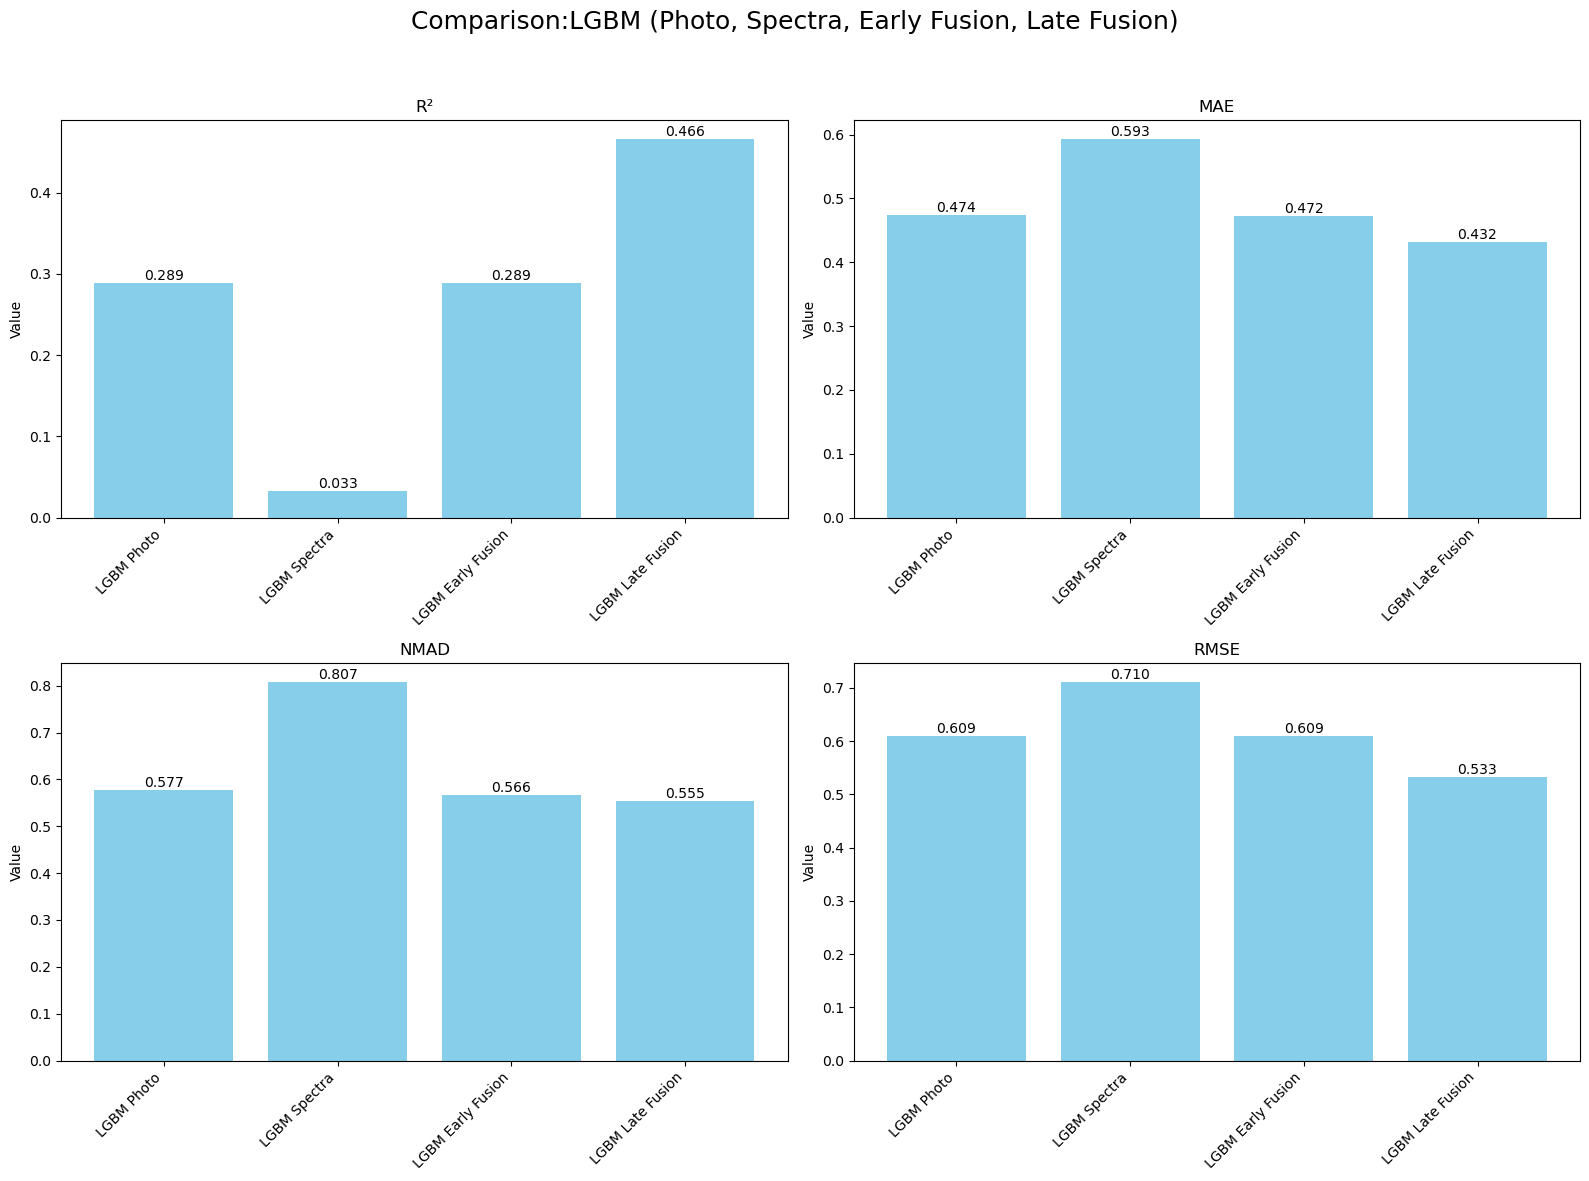

In [25]:
x = np.arange(len(methods))
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
axs = axs.flatten()
for i, metric in enumerate(metrics_names):
    axs[i].bar(x, values[metric], color='skyblue')
    axs[i].set_xticks(x)
    axs[i].set_xticklabels(methods, rotation=45, ha='right')
    axs[i].set_title(metric)
    axs[i].set_ylabel("Value")
    for j, v in enumerate(values[metric]):
        axs[i].text(j, v, f"{v:.3f}", ha='center', va='bottom', fontsize=10)
plt.suptitle("Comparison:LGBM (Photo, Spectra, Early Fusion, Late Fusion)", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Visualization of runtimes:

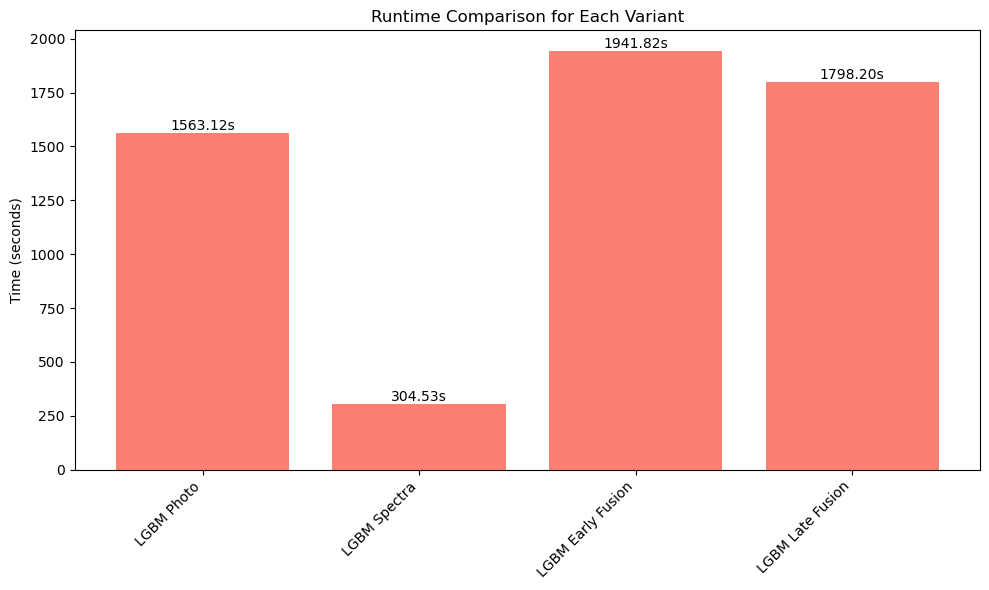

In [26]:
runtime_methods = list(runtime.keys())
runtime_values = [runtime[m] for m in runtime_methods]

plt.figure(figsize=(10, 6))
plt.bar(runtime_methods, runtime_values, color='salmon')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Time (seconds)")
plt.title("Runtime Comparison for Each Variant")
for i, t in enumerate(runtime_values):
    plt.text(i, t, f"{t:.2f}s", ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()